In [6]:
import numpy as np
from numpy import sqrt, log, log10, abs, pi
from scipy.stats import norm
import matplotlib.pyplot as plt
import pickle
from util import trapz
from matplotlib.patches import Ellipse
import matplotlib.ticker as ticker
import spectra
import matplotlib.image as mpimg

In [7]:
NT = 2**13
NK = 2**11
NX = 10000
L_MAX = 2500
xmin = 0.01
xmax = 3000
a0 = 1.e-6
a0_pca = 5.e-6
a_rec = 1/1100
A = np.linspace(a0, a_rec, 2*NT)
K = np.linspace(.1, 1200, NK)



#physical params
# physical parameters
h = 0.5
OmegaM0 = 1.0
OmegaB0 = 0.05
OmegaR0 = 4.2e-5/h**2
OmegaN0 = OmegaR0*(1-1/1.68)
OmegaG0 = OmegaR0 - OmegaN0
OmegaC0 = OmegaM0 - OmegaB0
wC = np.zeros(2*NT)
wN = np.ones(2*NT)*1/3
cs2C = np.zeros((2*NT, NK))
cs2N = np.ones((2*NT, NK))*1/3

In [8]:
# background
OmegaB = OmegaB0 * A[::2]**-3
OmegaC = OmegaC0 * A[::2]**-3
OmegaN = OmegaN0 * A[::2]**-4
OmegaG = OmegaG0 * A[::2]**-4
OmegaD = OmegaN + OmegaC
a_eq = (OmegaR0/OmegaM0)
H =  A[::2] * np.sqrt(OmegaB + OmegaC + OmegaG+ OmegaN) 
TAU = trapz(A[::2], 1/(A[::2] * H))

k_horizon = (np.pi/4)/TAU
ktau_horizon = .01025 # (one half wavelength inside horizon)
K_Mpc = K/4400
TAU_Gyr = 14*TAU

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


# Plot  w-only PCs

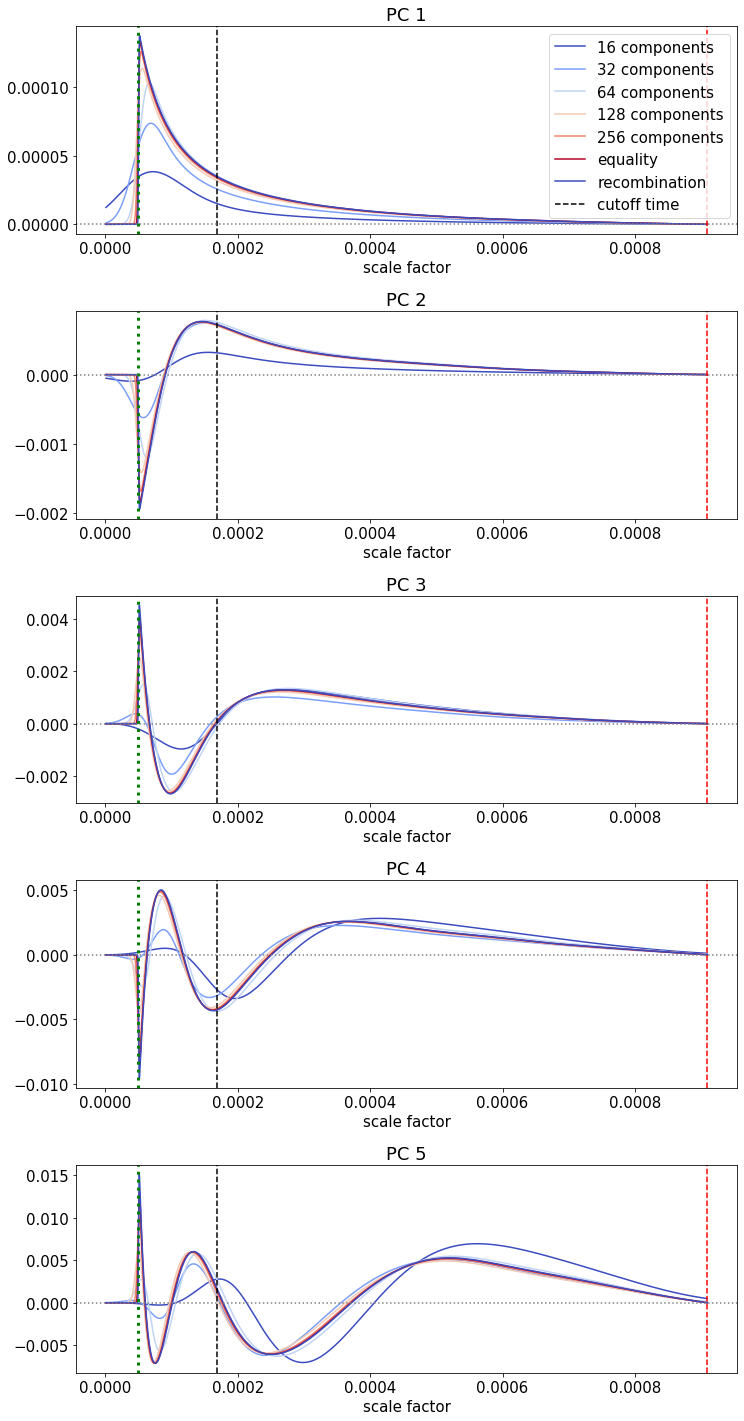

In [27]:
# load PCs and SVs
PC_q = np.array(
    [pickle.load(open("output/w-only/PC_q-"+str(q)+"_t-7.p", "rb")) for q in range(4,11)])
SV_q = np.array(
    [pickle.load(open("output/w-only/SV_q-"+str(q)+"_t-7.p", "rb"))[:10] for q in range(4,11)])

# flip PCs:
for i in range(7):
    for j in range(10):
        PC_q[i,j,:]*=np.sign(np.sum(PC_q[i,j,:]))

# plot the first 5 w PCs and save as pdf.
plt.figure(figsize=(20,20))
for n in range(5):
    plt.subplot(5,2,n*2+1)
    plt.gca().set_prop_cycle('color',plt.cm.coolwarm(np.linspace(.0,1,6)))
    #leg =['128 components','512 components','1024 components','2048 components',
    #           '4096 components', 'equality', 'recombination', 'cutoff time']
    plt.title('PC '+str(n+1))
    #plt.semilogx()
    plt.plot(A[::2],PC_q[:,n].T/sqrt(SV_q[:,n]))
    plt.axvline(a_eq,color = 'black',linestyle='--')
    plt.axvline(a_rec,color = 'red',linestyle='--')
    plt.axvline(.00005,color = 'green',linestyle=':',linewidth=3)
    plt.axhline(0,color='gray',linestyle=':')
    plt.xlabel('scale factor')
    if n==0:
        leg =['16 components','32 components','64 components','128 components','256 components',
              'equality', 'recombination', 'cutoff time']
        plt.legend(leg)
    #plt.semilogx()
    #plt.show()
    """
    plt.subplot(5,2,n*2+2)
    plt.gca().set_prop_cycle('color',plt.cm.coolwarm(np.linspace(.0,1,6)))
    #leg =['128 components','512 components','1024 components','2048 components',
    #           '4096 components', 'equality', 'recombination', 'cutoff time']
    plt.title('PC '+str(n+1) + ' (early time)')
    plt.plot(A[::2],PC_q[:,n].T/sqrt(SV_q[:,n]))
    plt.axvline(a_eq,color = 'black',linestyle='--')
    plt.axvline(a_rec,color = 'red',linestyle='--')
    plt.axvline(.00005,color = 'green',linestyle=':',linewidth=3)
    plt.axhline(0,color='gray',linestyle=':')
    plt.xlabel('scale factor')
    plt.xlim(0, 0.0001)
    #plt.semilogx()
    """
plt.tight_layout()
plt.savefig('plots/w_PCs.pdf')  
plt.show()

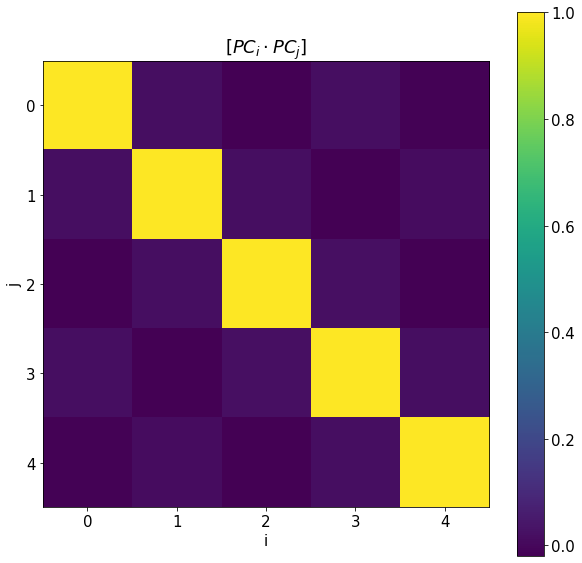

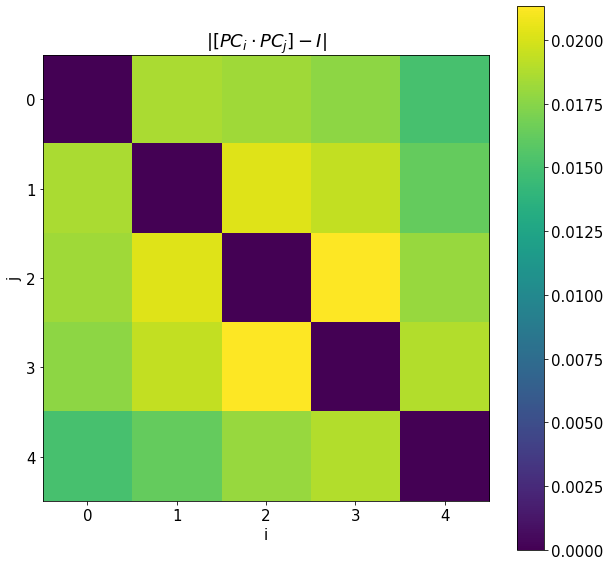

In [11]:
"""W-only orthogonality plot"""
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

plt.figure(figsize=(10,10))
PC_normed = np.copy(PC_q[5,:,:])
for i in range(5):
    PC_normed[i,:]/=np.linalg.norm(PC_normed[i,:])
outer = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        outer[i,j] = np.dot(PC_normed[i,:],PC_normed[j,:])
plt.imshow(outer)
plt.colorbar()
plt.title("$[PC_i \cdot PC_j]$")
plt.xlabel('i')
plt.ylabel('j')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(abs(outer-np.eye(5)))
plt.title("$|[PC_i \cdot PC_j] - I|$")
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar()
plt.show()

In [12]:
def RRMSR(x1,x2):
    # relative root mean square error
    rmse = np.sqrt(np.mean((x2-x1)**2))
    rms2 = np.sqrt(np.mean(x2**2))
    return rmse/rms2

def RMS(x):
    return np.sqrt(np.mean(x**2))

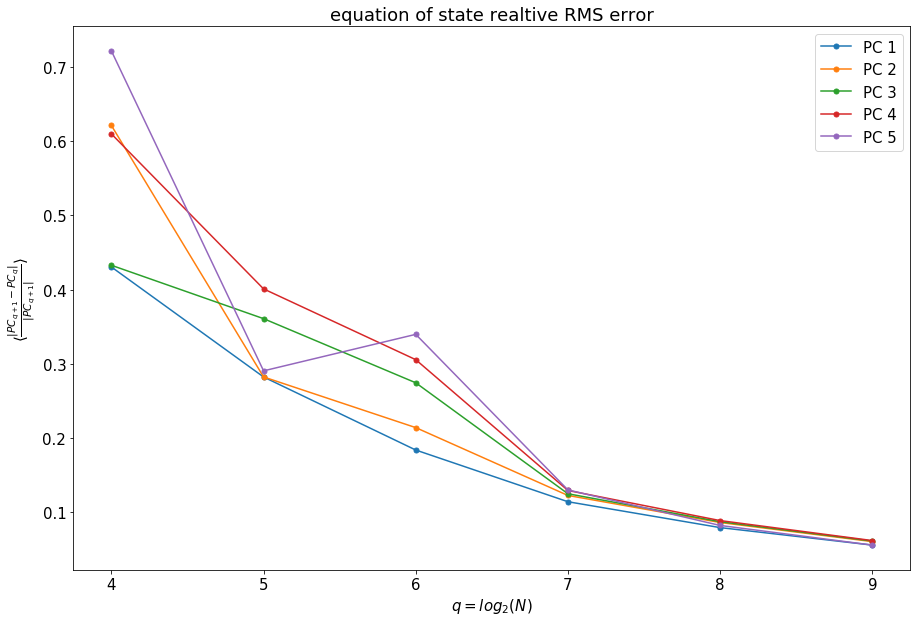

In [13]:
plt.figure(figsize=(15,10))
plt.title('equation of state realtive RMS error')
w_err = np.zeros((6,5))
for q in range(6):
    for n in range(5):
        x1 =  PC_q[q,n,:].T/sqrt(SV_q[q,n])
        x2 = PC_q[q+1,n,:].T/sqrt(SV_q[q+1,n])
        w_err[q,n]=RRMSR(x1,x2)

plt.plot([4,5,6,7,8,9],w_err[:,0], marker='.', markersize=10)
plt.plot([4,5,6,7,8,9],w_err[:,1], marker='.', markersize=10)
plt.plot([4,5,6,7,8,9],w_err[:,2], marker='.', markersize=10)
plt.plot([4,5,6,7,8,9],w_err[:,3], marker='.', markersize=10)
plt.plot([4,5,6,7,8,9],w_err[:,4], marker='.', markersize=10)
plt.xlabel('$q=log_2(N)$')
plt.ylabel(r'$\langle \frac{|PC_{q+1} - PC_q|}{|PC_{q+1}|} \rangle$')
plt.legend(['PC 1','PC 2','PC 3','PC 4','PC 5'])
plt.savefig('plots/w_PC_err.pdf')  
plt.show()

# Plot cs2-only PCs

(5, 10, 8192, 2048)


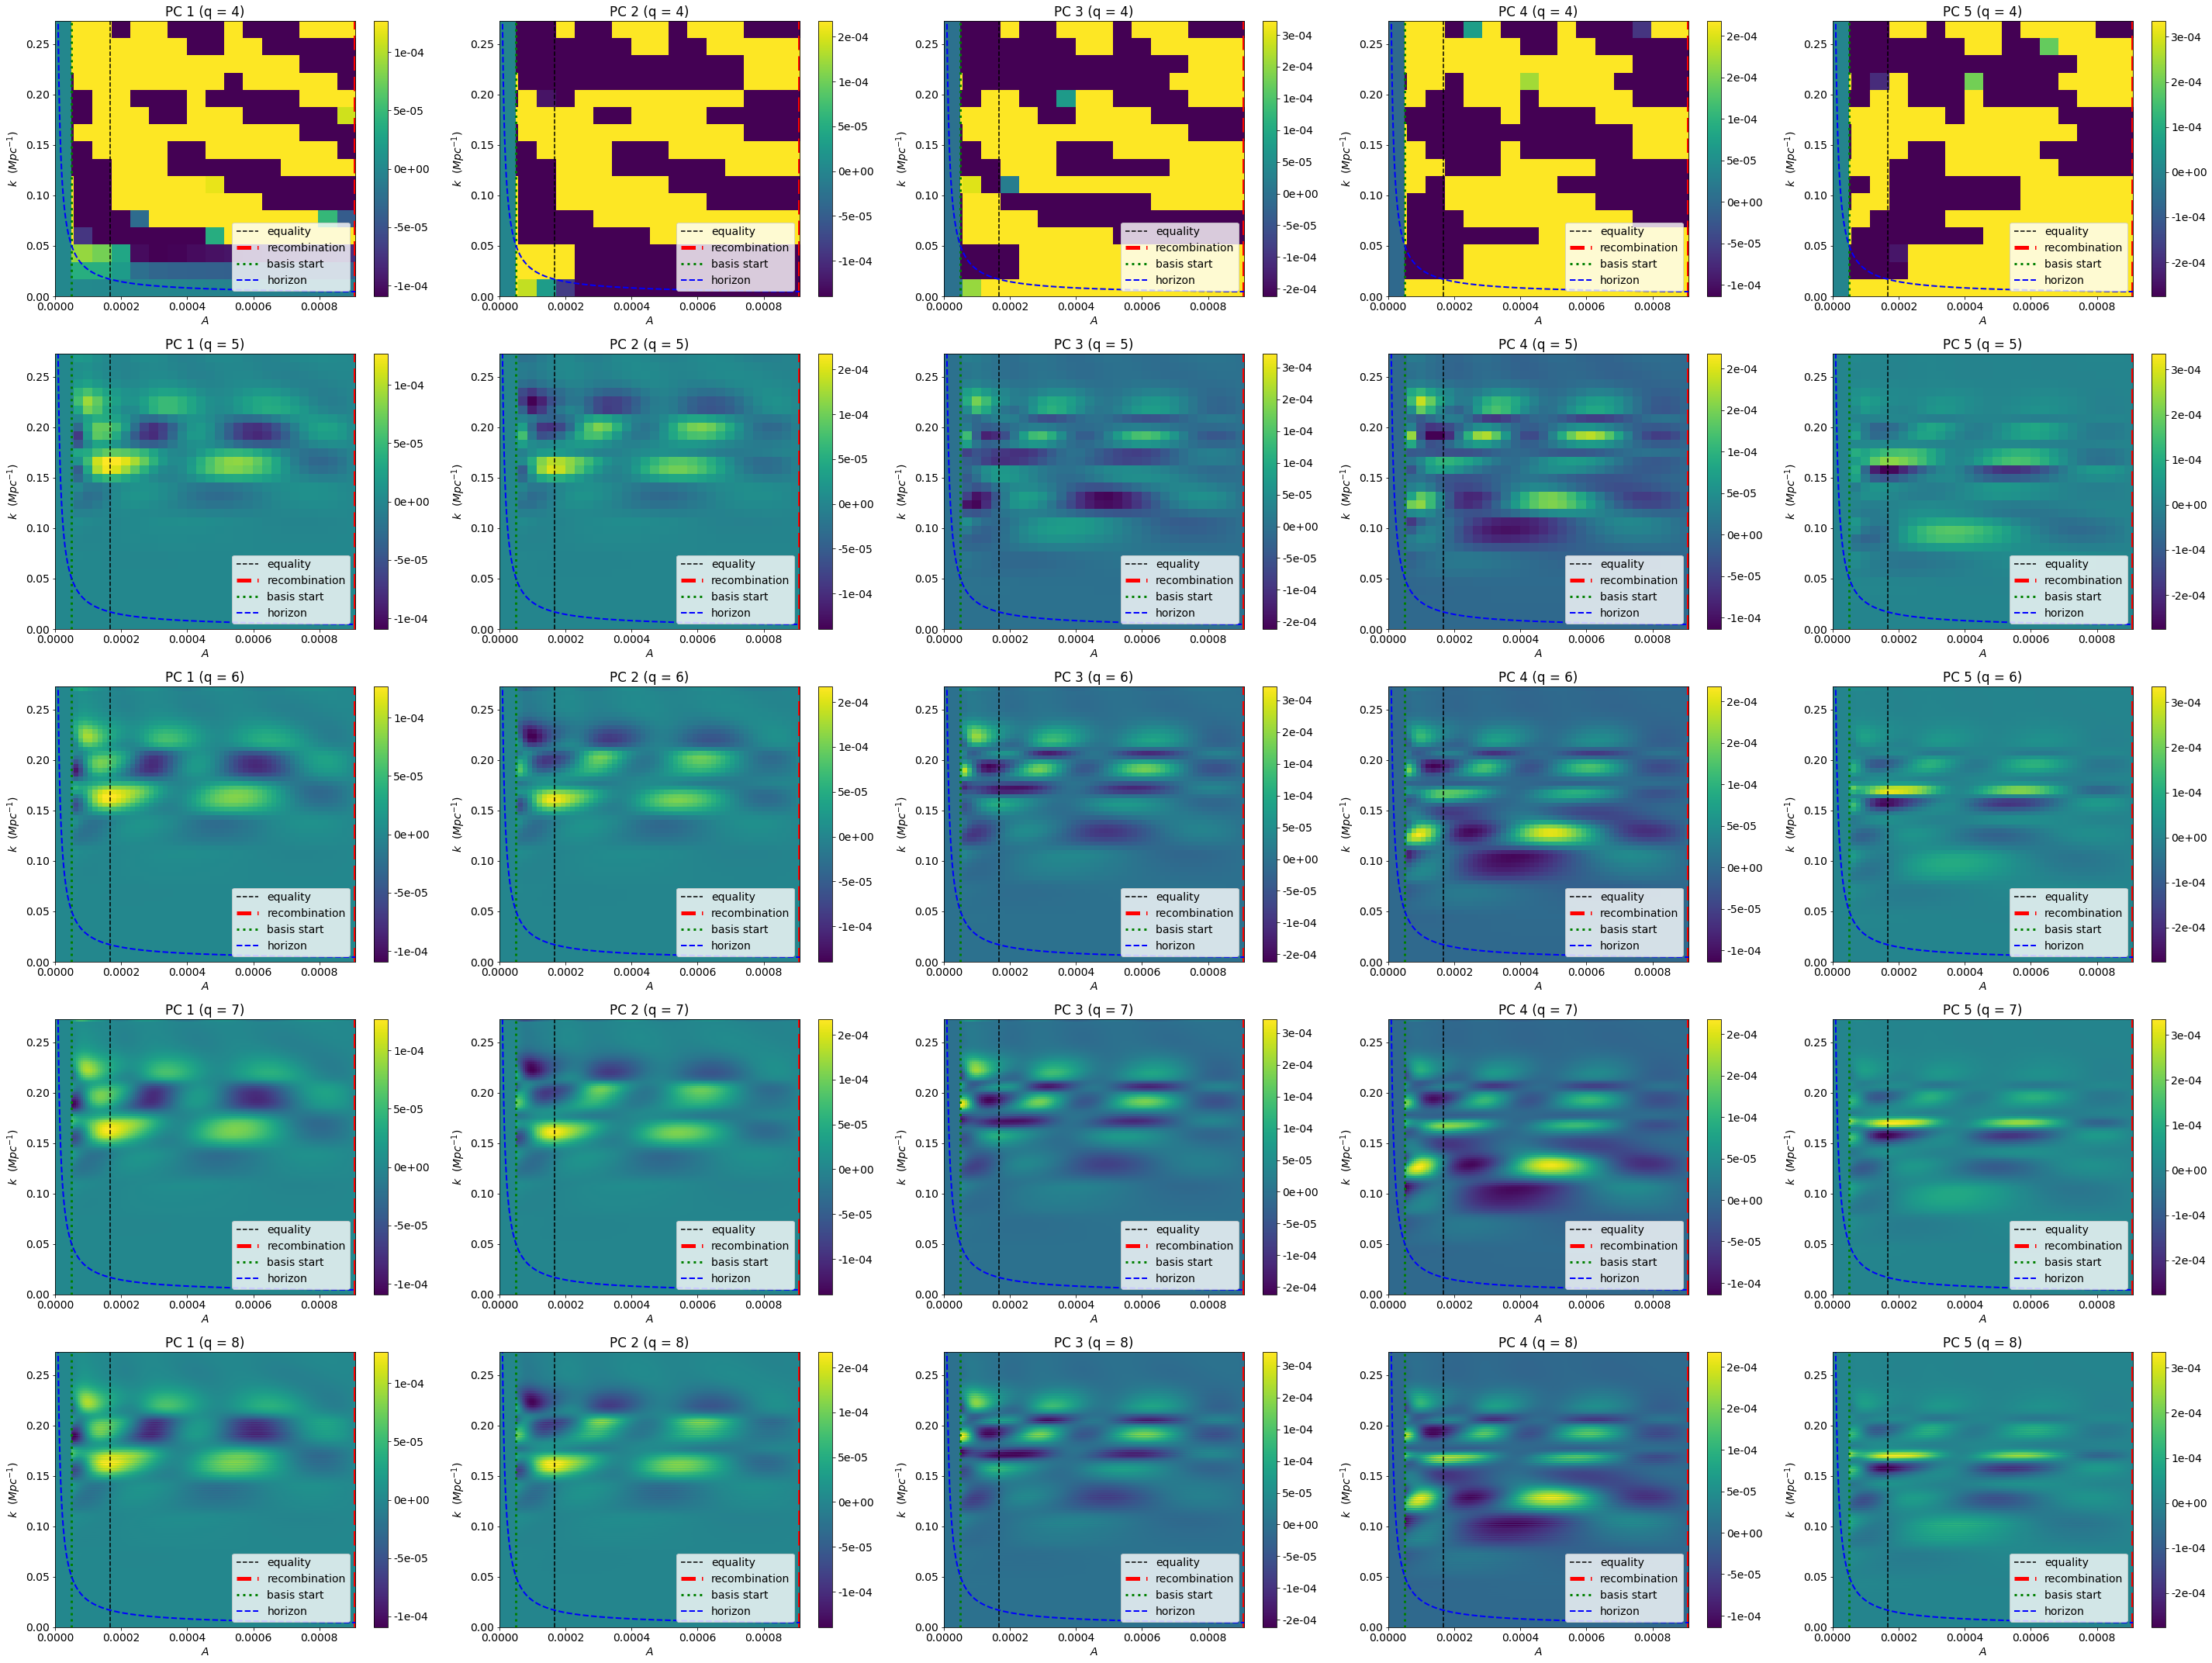

In [14]:
plt.rcParams.update({'font.size': 14})
# load PCs and SVs
PC_q = np.array(
    [pickle.load(open("output/cs2-only/PC_q-"+str(q)+"_t-7.p", "rb")) for q in range(4,9)])
SV_q = np.array(
    [pickle.load(open("output/cs2-only/SV_q-"+str(q)+"_t-7.p", "rb"))[:10] for q in range(4,9)])
print(np.shape(PC_q))
# flip and normalize PCs:
for i in range(5):
    for j in range(5):
        PC_q[i,j,:,:]*=np.sign(np.sum(PC_q[i,j,:,:]))

fig, axs = plt.subplots(5, 5,figsize=(40,30))

vmaxes = [0]*5
vmins = [0]*5
for n in range(5):
    vmaxes[n]=np.max(PC_q[3,n,:,:].T/sqrt(SV_q[3,n]))
    vmins[n]=np.min(PC_q[3,n,:,:].T/sqrt(SV_q[3,n]))

for q in range(5):
    for n in range(5): 
        ax = axs[q, n]
        p = ax.imshow(PC_q[q,n,:,:].T/sqrt(SV_q[q,n]),extent=[0,a_rec,0,K_Mpc[-1]],
                  aspect='auto', origin='lower', vmax=vmaxes[n], vmin=vmins[n])
        plt.colorbar(p,ax=ax,format='%.0e')
        #label axes
        ax.set_title("PC {} (q = {})".format(n+1,q+4))
        ax.set_xlabel(r'$A$')
        ax.set_ylabel(r'$k$  $(Mpc^{-1})$')
        
        # add some guidelines
        ax.axvline(a_eq,color = 'black',linestyle='--')
        ax.axvline(a_rec,color = 'red',linestyle='--',linewidth=5)
        ax.axvline(.00005,color = 'green',linestyle=':',linewidth=3)
        ax.plot(A[::2], k_horizon/4400, color='blue', linewidth=2, linestyle='--')
        ax.legend(['equality','recombination','basis start', 'horizon'], loc=4)
        ax.set_ylim(0,max(K_Mpc))

plt.tight_layout()
plt.savefig('plots/cs2_PCs.pdf')  
plt.show()



(10, 8192, 2048)


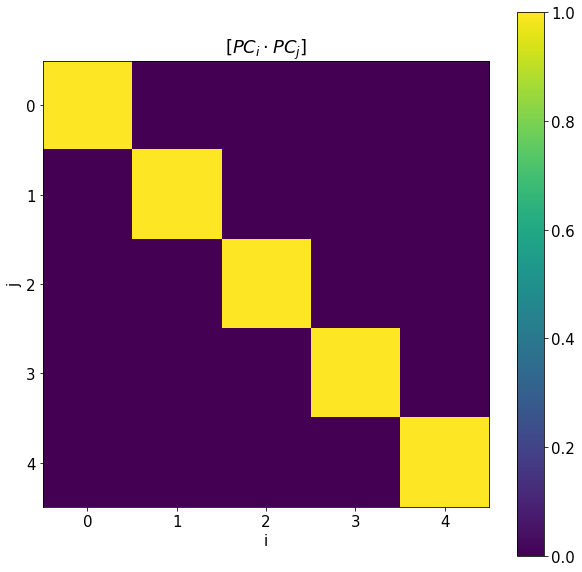

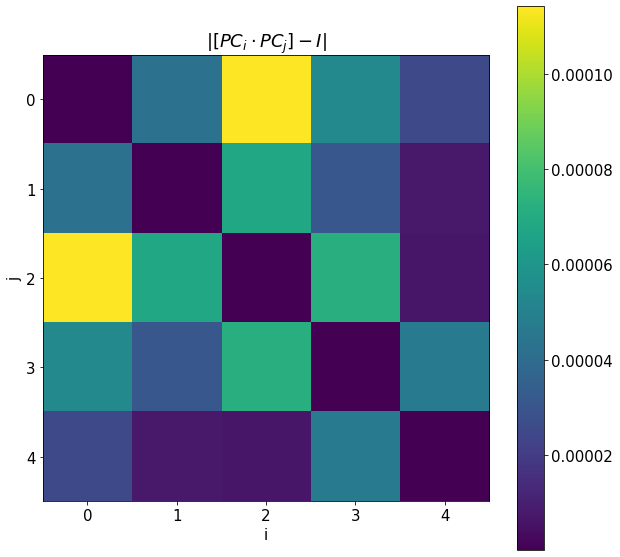

In [26]:
"""CS2-only orthogonality plot"""
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

PC_normed = np.copy(PC_q[4])
print(np.shape(PC_normed))
for i in range(5):
    PC_normed[i]/=np.linalg.norm(PC_normed[i])
outer = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        outer[i,j] = np.sum(PC_normed[i]*PC_normed[j])
        

plt.figure(figsize=(10,10))
plt.imshow(outer)
plt.colorbar()
plt.title("$[PC_i \cdot PC_j]$")
plt.xlabel('i')
plt.ylabel('j')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(abs(outer-np.eye(5)))
plt.title("$|[PC_i \cdot PC_j] - I|$")
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar()
plt.show()

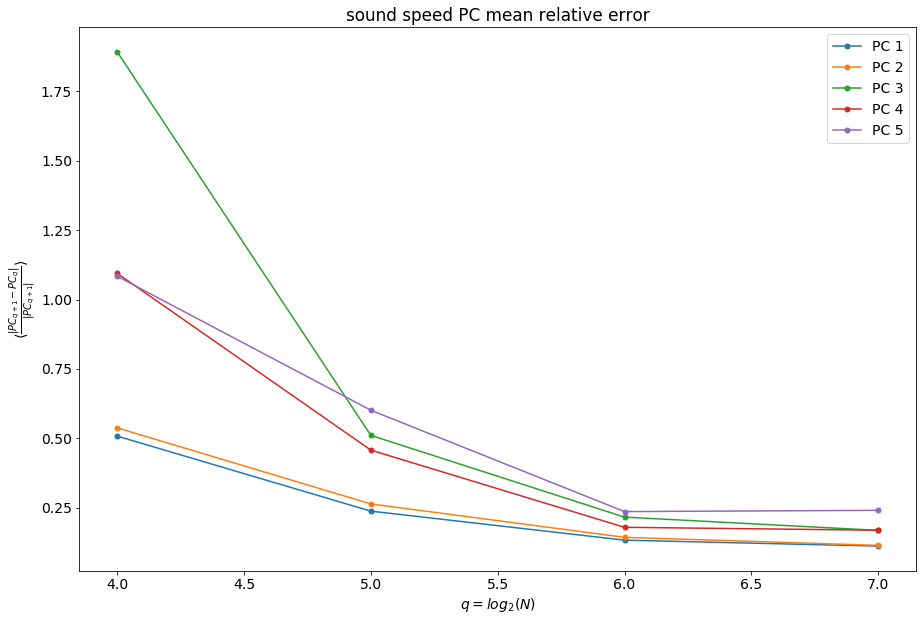

In [59]:


plt.figure(figsize=(15,10))
plt.title('sound speed PC mean relative error')
minval = 1.e-9
cs2_err = np.zeros((4,5))
for q in range(4):
    for n in range(5):
        x1 =  PC_q[q,n,:,:].T/sqrt(SV_q[q,n])
        x2 = PC_q[q+1,n,:,:].T/sqrt(SV_q[q+1,n])
        cs2_err[q,n]=RRMSR(x1,x2)

plt.plot([4,5,6,7],cs2_err[:,0], marker='.', markersize=10)
plt.plot([4,5,6,7],cs2_err[:,1], marker='.', markersize=10)
plt.plot([4,5,6,7],cs2_err[:,2], marker='.', markersize=10)
plt.plot([4,5,6,7],cs2_err[:,3], marker='.', markersize=10)
plt.plot([4,5,6,7],cs2_err[:,4], marker='.', markersize=10)
plt.xlabel('$q=log_2(N)$')
plt.ylabel(r'$\langle \frac{|PC_{q+1} - PC_q|}{|PC_{q+1}|} \rangle$')
plt.legend(['PC 1','PC 2','PC 3','PC 4','PC 5'])
plt.savefig('plots/cs2_PC_err.pdf')  
plt.show()

## Joint PCs

In [ ]:
"""Joint PCs"""
# load PCs and SVs
wPC_q = np.array(
    [pickle.load(open("output/w-cs2/wPC_q-"+str(q)+"_t-7.p", "rb")) for q in range(4,9)])
cs2PC_q = np.array(
    [pickle.load(open("output/w-cs2/cs2PC_q-"+str(q)+"_t-7.p", "rb")) for q in range(4,9)])
SV_q = np.array(
    [pickle.load(open("output/w-cs2/SV_q-"+str(q)+"_t-7.p", "rb"))[:10] for q in range(4,9)])


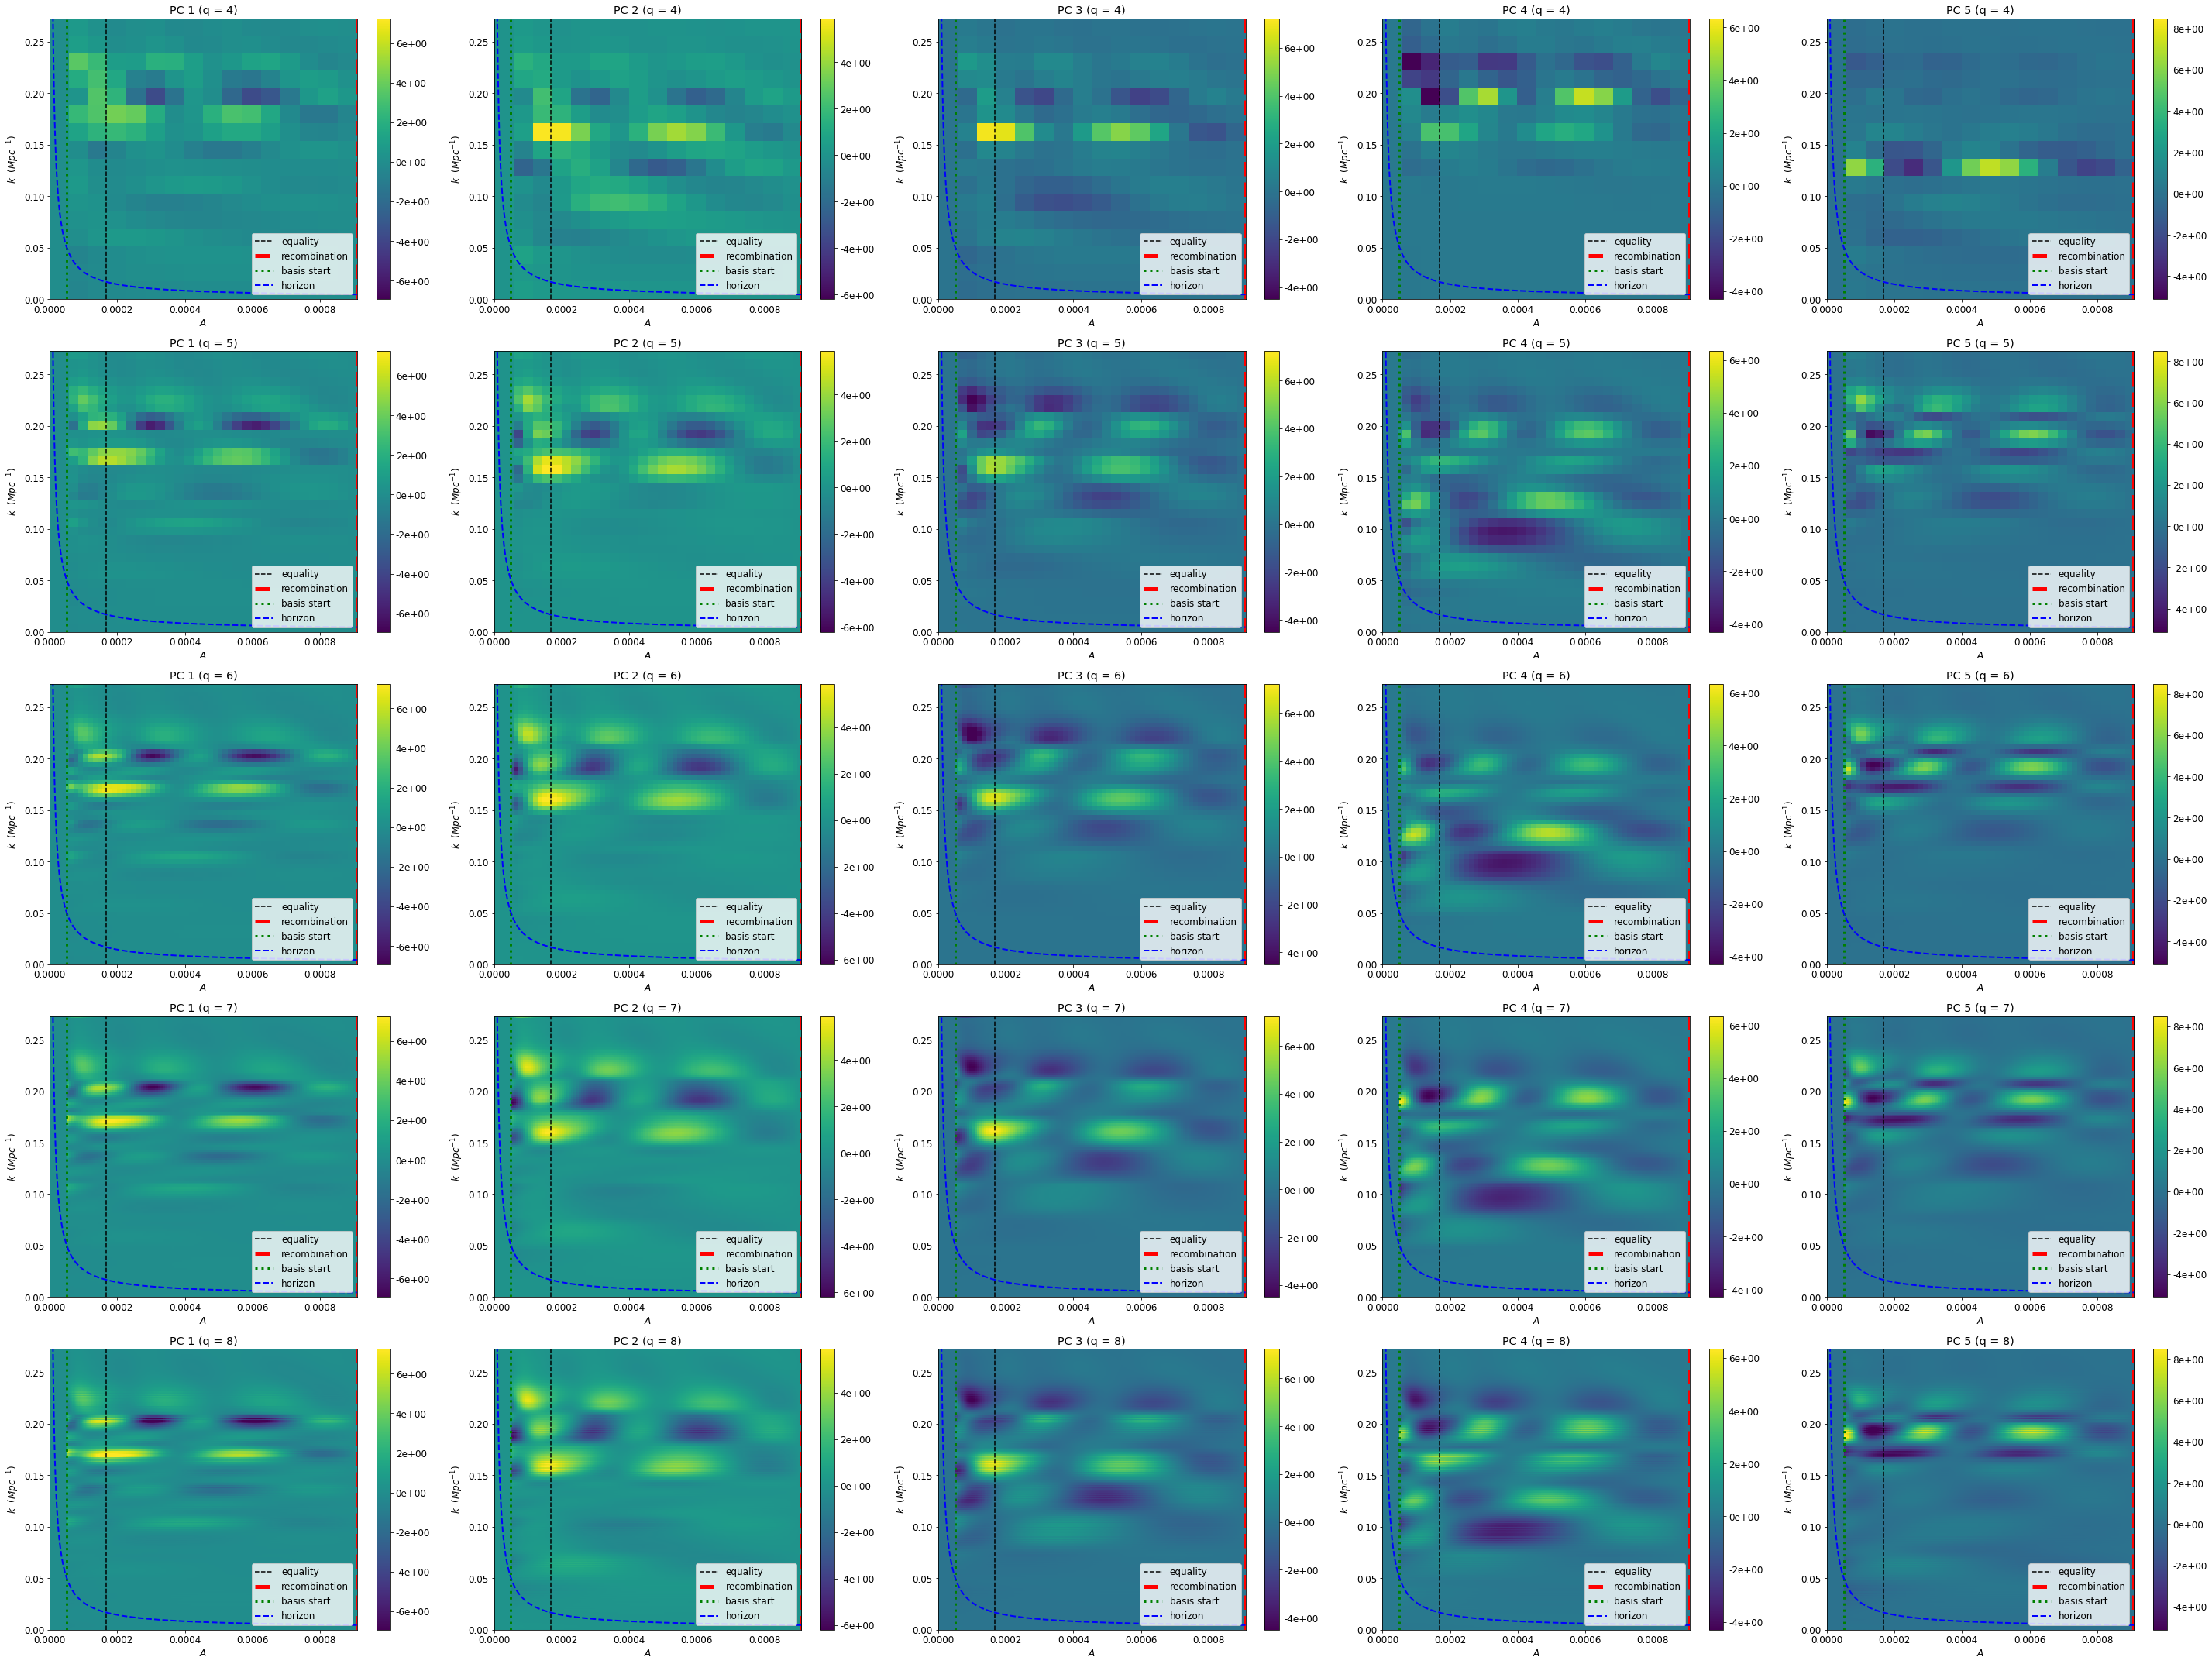

In [81]:
# flip PCs:
for i in range(5):
    for j in range(10):
        wPC_q[i,j,:]*=np.sign(wPC_q[i,j,100])
        cs2PC_q[i,j,:,:]*=np.sign(np.sum(cs2PC_q[i,j,:,:]))

vmaxes = [0]*5
vmins = [0]*5
for n in range(5):
    vmaxes[n]=np.max(cs2PC_q[3,n,:,:].T/RMS(cs2PC_q[3,n,:,:]))
    vmins[n]=np.min(cs2PC_q[3,n,:,:].T/RMS(cs2PC_q[3,n,:,:]))

        
fig, axs = plt.subplots(5, 5,figsize=(40,30))


plt.rcParams.update({'font.size': 12})
for q in range(5):
    for n in range(5): 
        ax = axs[q, n]
        p = ax.imshow(cs2PC_q[q,n,:,:].T/RMS(cs2PC_q[q,n,:,:]),extent=[0,a_rec,0,K_Mpc[-1]],
                      aspect='auto', origin='lower', vmax=vmaxes[n], vmin=vmins[n])
        plt.colorbar(p,ax=ax,format='%.0e')
        #label axes
        ax.set_title("PC {} (q = {})".format(n+1,q+4))
        ax.set_xlabel(r'$A$')
        ax.set_ylabel(r'$k$  $(Mpc^{-1})$')
        
        # add some guidelines
        ax.axvline(a_eq,color = 'black',linestyle='--')
        ax.axvline(a_rec,color = 'red',linestyle='--',linewidth=5)
        ax.axvline(.00005,color = 'green',linestyle=':',linewidth=3)
        ax.plot(A[::2], k_horizon/4400, color='blue', linewidth=2, linestyle='--')
        ax.legend(['equality','recombination','basis start', 'horizon'], loc=4)
        ax.set_ylim(0,max(K_Mpc))
plt.tight_layout()
plt.savefig('plots/joint_cs2_PCs.pdf')  
plt.show()



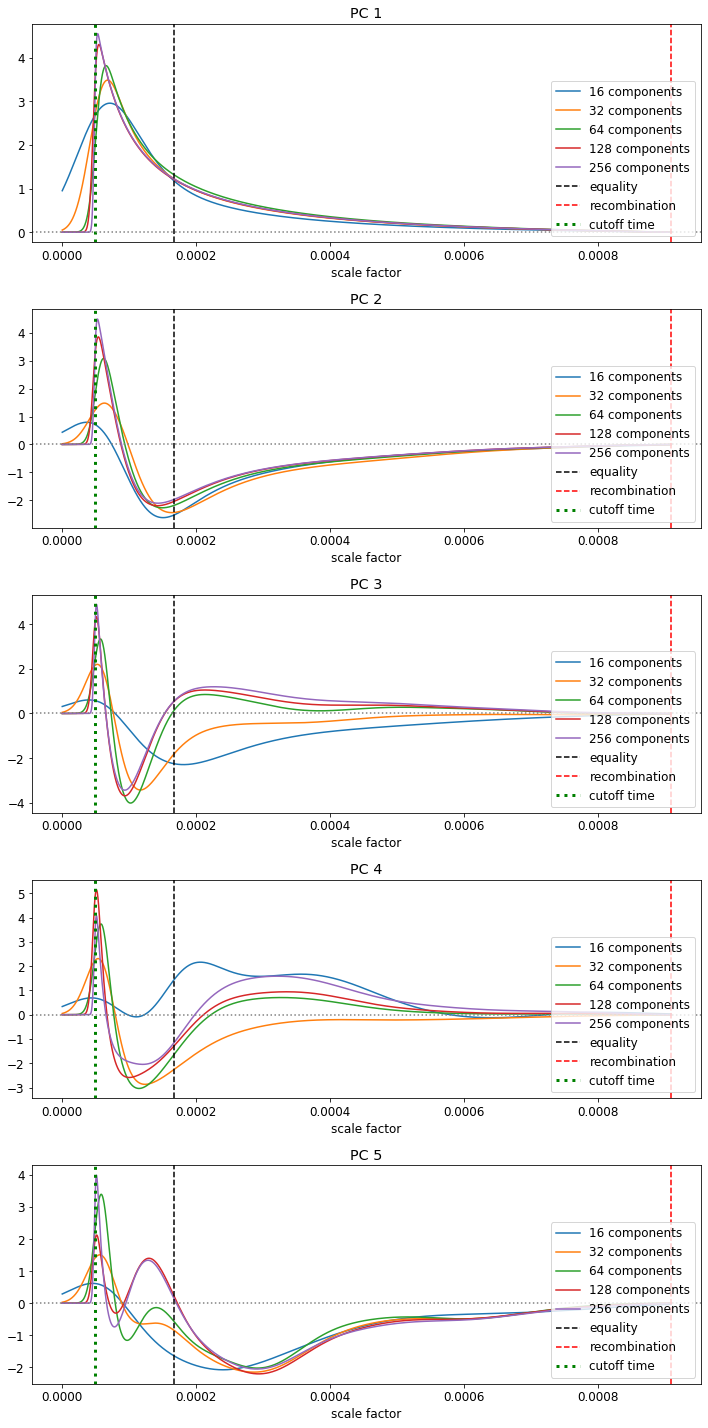

In [77]:
# plot the first 5 w PCs and save as pdf.
plt.figure(figsize=(10,20))
for n in range(5):
    plt.subplot(5,1,n+1)
    plt.gca().set_prop_cycle(None)
    plt.title('PC '+str(n+1))
    #plt.semilogx()
    #plt.plot(A[::2],wPC_q[:,n].T/sqrt(SV_q[:,n]))
    for q in range(5):
        #plt.plot(A[::2],wPC_q[q,n].T/RMS(wPC_q[q,n].T))
        plt.plot(A[::2],wPC_q[q,n].T/RMS(wPC_q[q,n].T))
    plt.axvline(a_eq,color = 'black',linestyle='--')
    plt.axvline(a_rec,color = 'red',linestyle='--')
    plt.axvline(.00005,color = 'green',linestyle=':',linewidth=3)
    plt.axhline(0,color='gray',linestyle=':')
    plt.xlabel('scale factor')
    #plt.semilogx()
    leg =['16 components','32 components','64 components','128 components','256 components', 'equality', 'recombination', 'cutoff time']
    plt.legend(leg,loc=4)
    #plt.semilogx()
plt.tight_layout()
plt.savefig('plots/joint_w_PCs.pdf')  
plt.show()

1.0 1.0
1.0 0.9999999999999999
0.9999999999999999 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.9999999999999999 1.0
1.0 1.0
1.0 0.9999999999999998
1.0 1.0
1.0 1.0
1.0 1.0
1.0 0.9999999999999999
0.9999999999999998 1.0
1.0 1.0
1.0 0.9999999999999999
1.0 1.0
0.9999999999999999 0.9999999999999999
1.0 1.0
1.0 0.9999999999999999


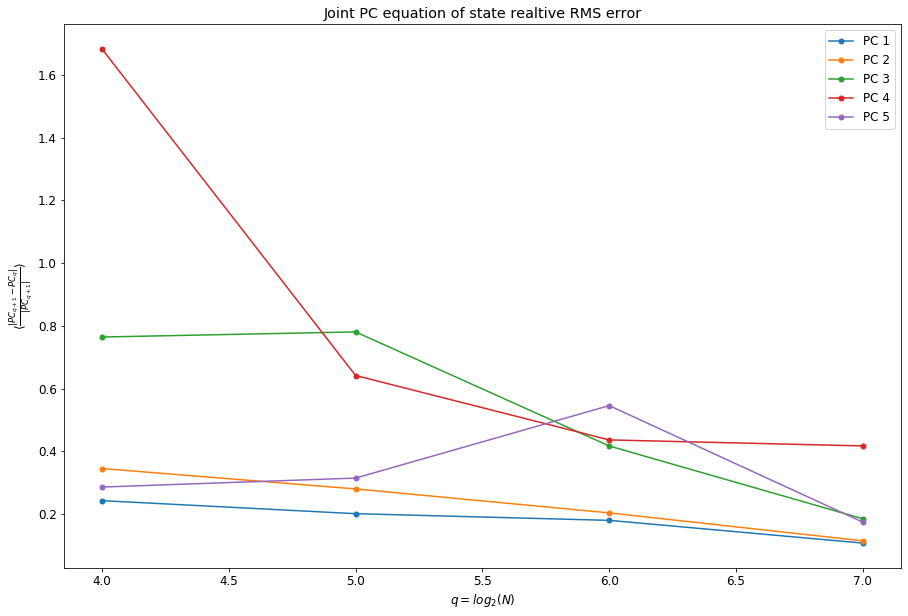

In [73]:
plt.figure(figsize=(15,10))
plt.title('Joint PC equation of state realtive RMS error')
w_err = np.zeros((4,5))
for q in range(4):
    for n in range(5):
        #x1 =  wPC_q[q,n,:].T/sqrt(SV_q[q,n])
        #x2 = wPC_q[q+1,n,:].T/sqrt(SV_q[q+1,n])
        x1 =  wPC_q[q,n,:].T/RMS(wPC_q[q,n,:].T)
        x2 = wPC_q[q+1,n,:].T/RMS(wPC_q[q+1,n,:].T)
        print(RMS(x1),RMS(x2))
        w_err[q,n]=RRMSR(x1,x2)

plt.plot([4,5,6,7],w_err[:,0], marker='.', markersize=10)
plt.plot([4,5,6,7],w_err[:,1], marker='.', markersize=10)
plt.plot([4,5,6,7],w_err[:,2], marker='.', markersize=10)
plt.plot([4,5,6,7],w_err[:,3], marker='.', markersize=10)
plt.plot([4,5,6,7],w_err[:,4], marker='.', markersize=10)
plt.xlabel('$q=log_2(N)$')
plt.ylabel(r'$\langle \frac{|PC_{q+1} - PC_q|}{|PC_{q+1}|} \rangle$')
plt.legend(['PC 1','PC 2','PC 3','PC 4','PC 5'])
plt.savefig('plots/joint_PC_w_err.pdf')  
plt.show()

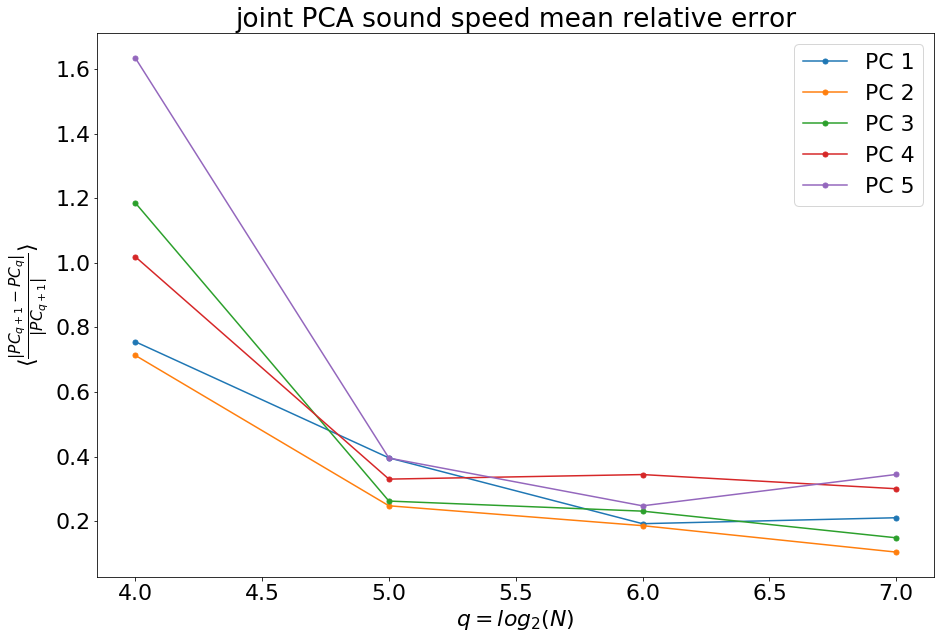

In [78]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 22})
plt.title('joint PCA sound speed mean relative error')
minval = 1.e-9
cs2_err = np.zeros((4,5))
for q in range(4):
    for n in range(5):
        minval = 1.e-9
        #x1 =  cs2PC_q[q,n,:,:].T/sqrt(SV_q[q,n])
        #x2 = cs2PC_q[q+1,n,:,:].T/sqrt(SV_q[q+1,n])
        x1 =  cs2PC_q[q,n,:,:].T/RMS(cs2PC_q[q,n,:,:])
        x2 = cs2PC_q[q+1,n,:,:].T/RMS(cs2PC_q[q+1,n,:,:])
        cs2_err[q,n]=RRMSR(x1,x2)

plt.plot([4,5,6,7],cs2_err[:,0], marker='.', markersize=10)
plt.plot([4,5,6,7],cs2_err[:,1], marker='.', markersize=10)
plt.plot([4,5,6,7],cs2_err[:,2], marker='.', markersize=10)
plt.plot([4,5,6,7],cs2_err[:,3], marker='.', markersize=10)
plt.plot([4,5,6,7],cs2_err[:,4], marker='.', markersize=10)
plt.xlabel('$q=log_2(N)$')
plt.ylabel(r'$\langle \frac{|PC_{q+1} - PC_q|}{|PC_{q+1}|} \rangle$')
plt.legend(['PC 1','PC 2','PC 3','PC 4','PC 5'])
plt.savefig('plots/joint_PC_cs2_err.pdf')  
plt.show()


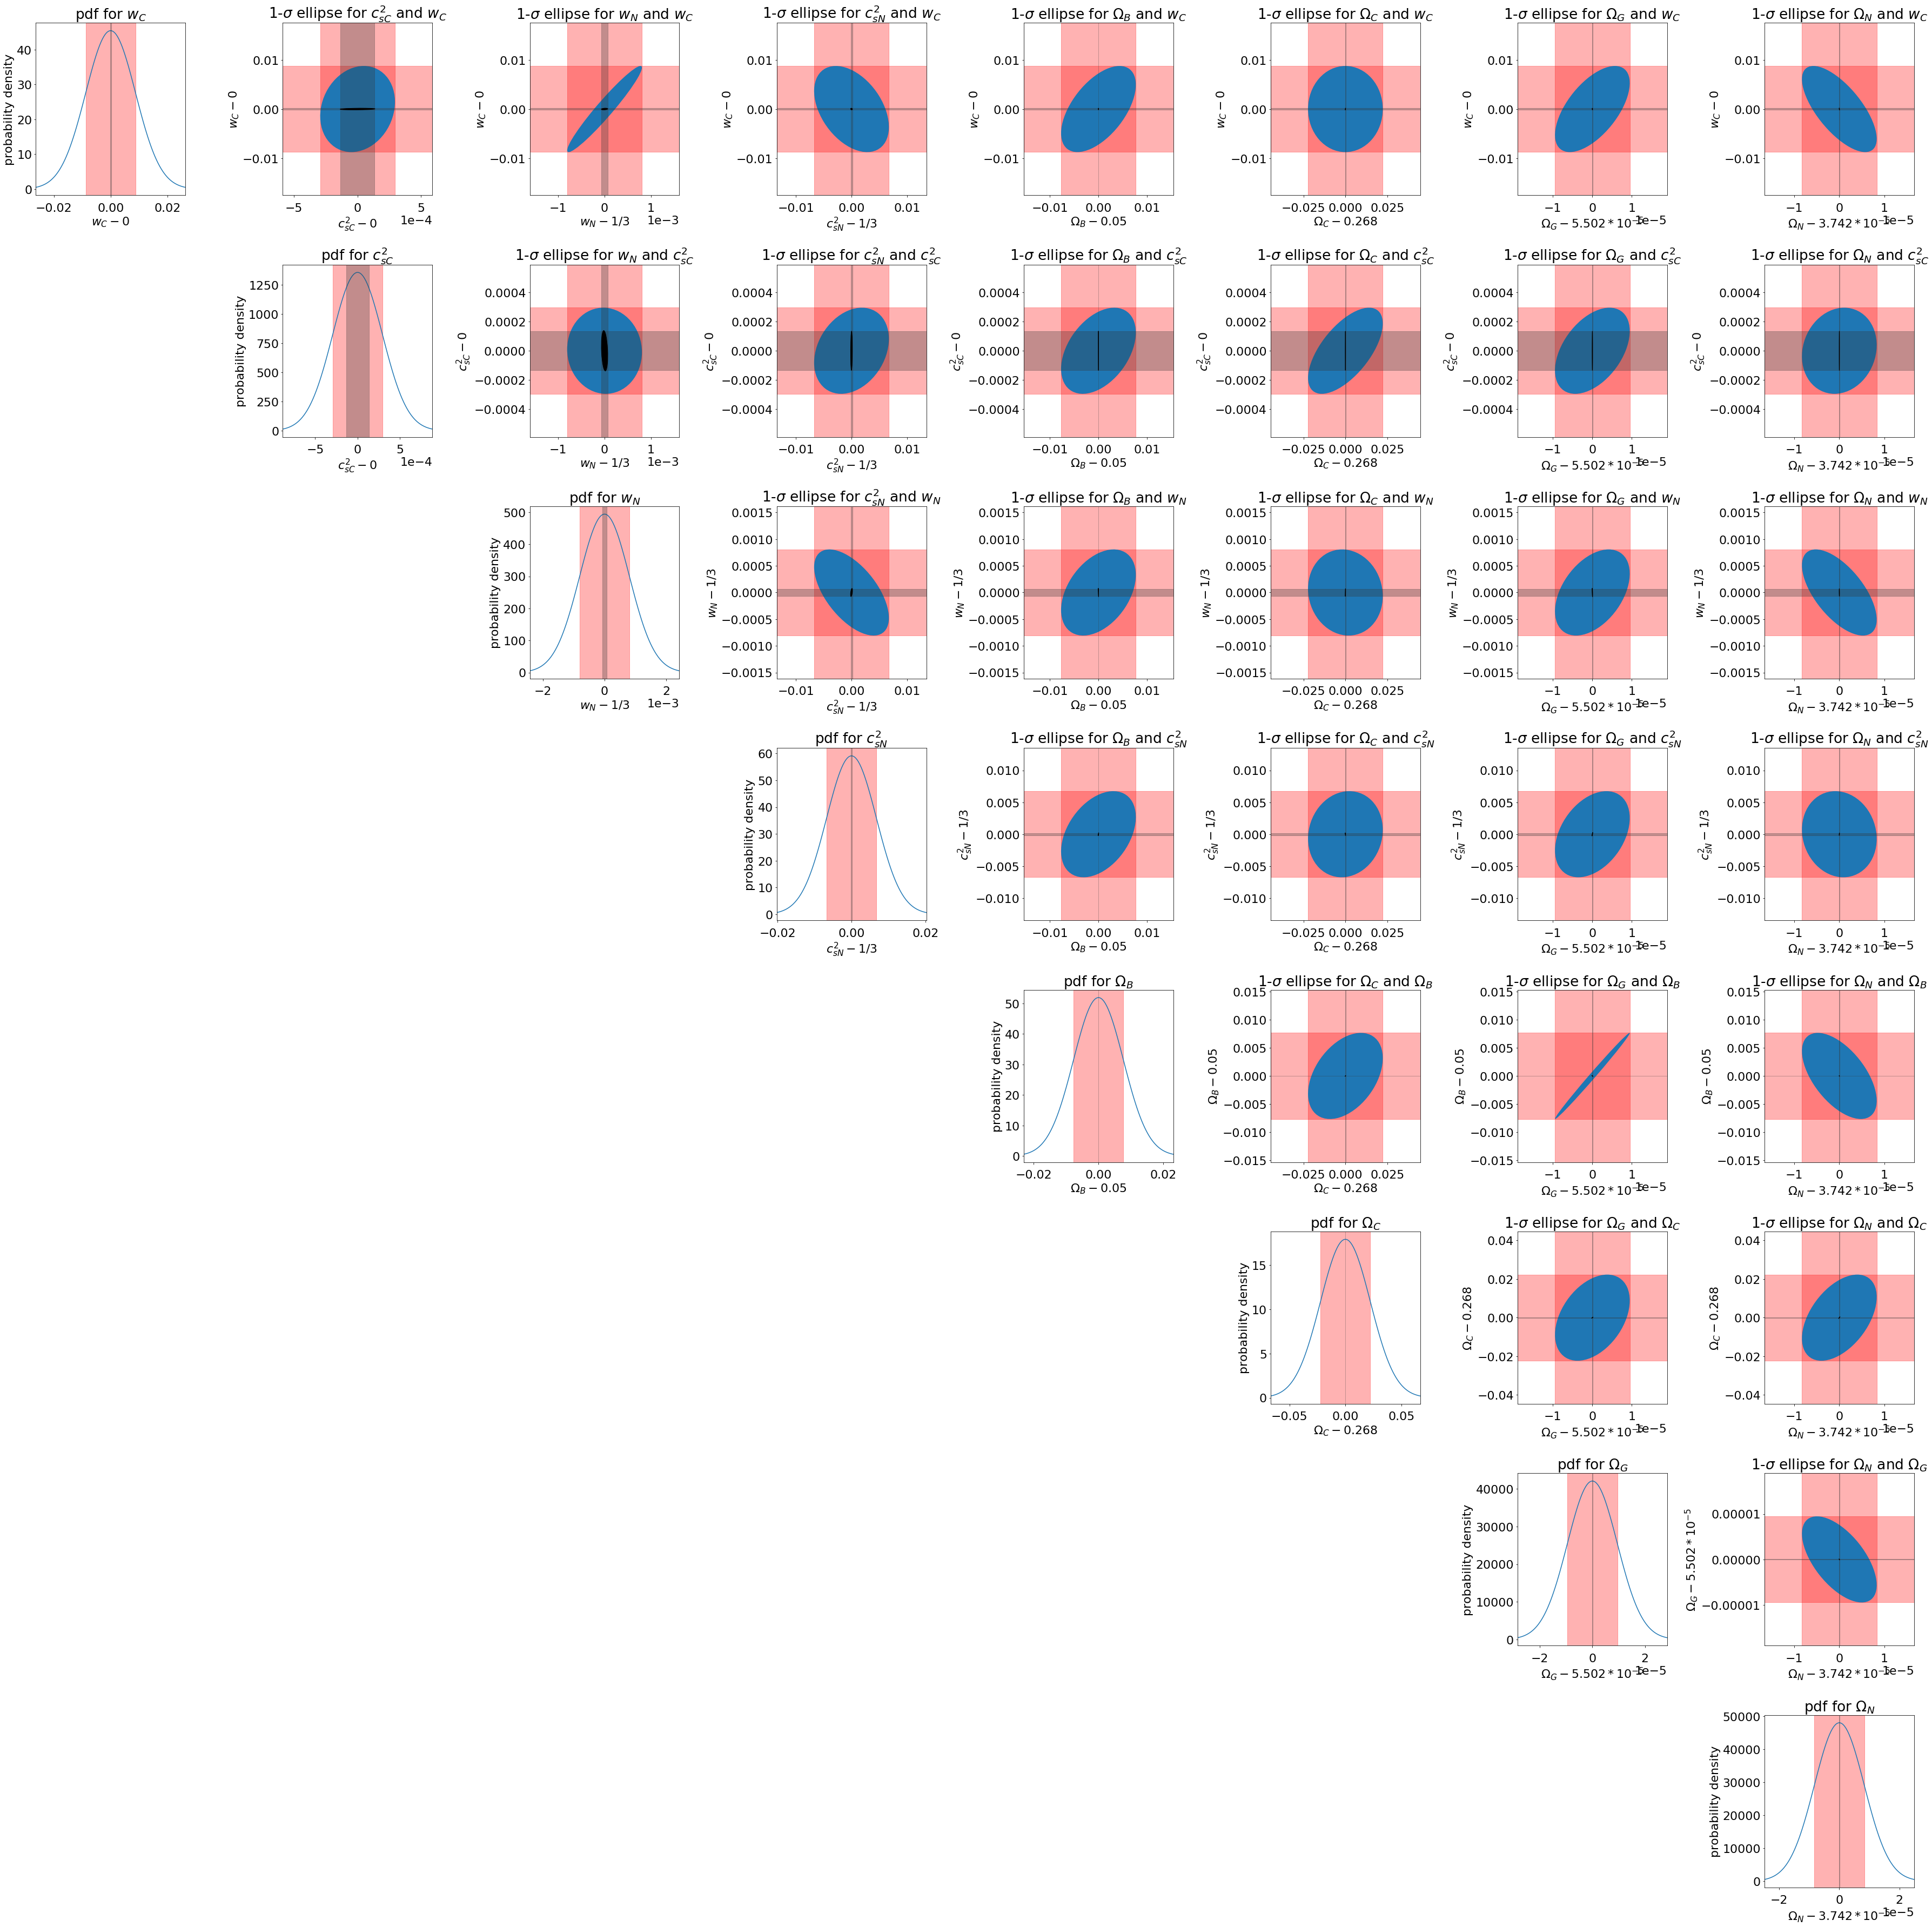

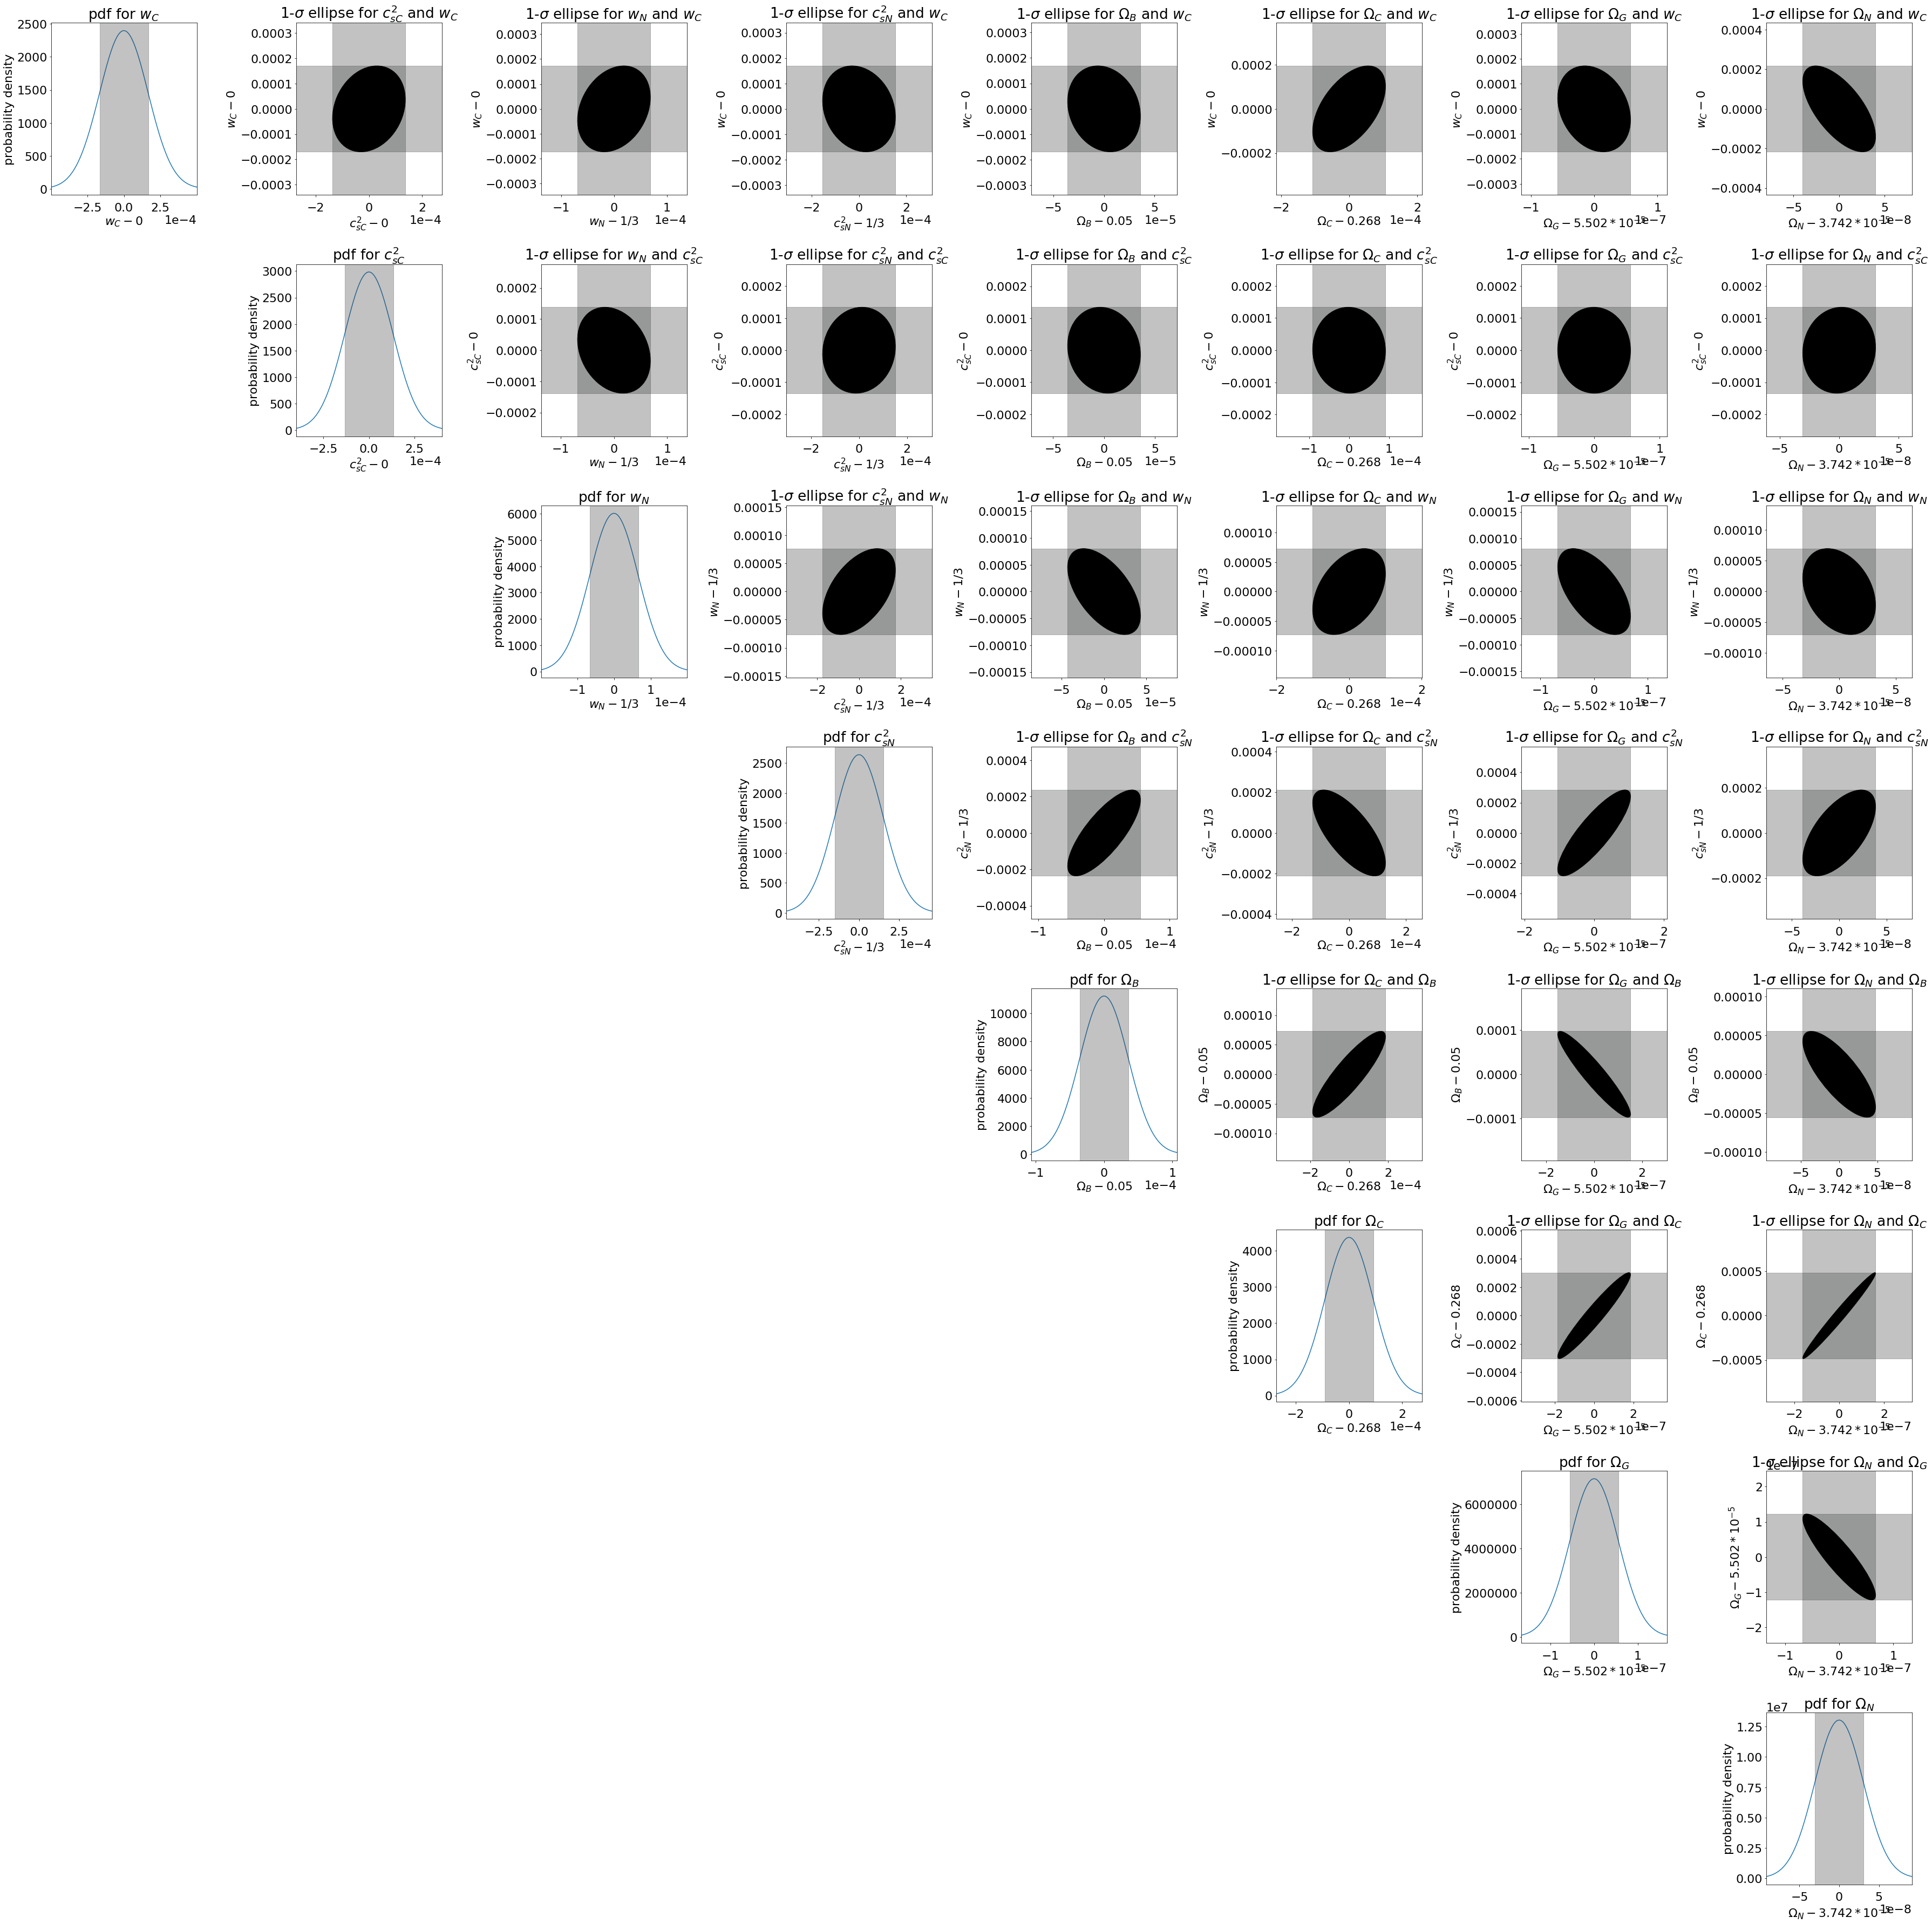

In [13]:
"""Plot ellipses from standard parameter Fisher"""
# parameter name list
param_names = ["w_C", "c_{sC}^2", "w_N", "c_{sN}^2", "\Omega_B", "\Omega_C", "\Omega_G", "\Omega_N", "h"]
param_vals = ["0", "0", "1/3", "1/3", "0.05", "0.268",
              "5.502 * 10^{-5}", "3.742 * 10^{-5}", ".05"]

# load Fisher matrix
F = pickle.load(open("output/params/F_t-7.p","rb"))
COV = np.linalg.inv(F)

# create the marginalized figure
plt.figure(figsize=(50,50))
# iterate over all (i, j) with j<=i (lower triangular indices):
NP = 8
for i,j in np.array(np.tril_indices(NP)).T:
    # create the subplot
    plt.subplot(NP,NP,NP*j+i+1, aspect='auto')
    ax = plt.gca()
    ax.tick_params(axis='x', which='major', pad=10)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(-3, 3))
    
    # on the diagonals plot the univariate gaussians
    if i==j:
        var = COV[i,i]
        var_m = 1/F[i,i]
        ax.axvspan(-sqrt(var), sqrt(var), alpha=0.3, color='red')
        ax.axvspan(-sqrt(var_m), sqrt(var_m), alpha=0.3, color='xkcd:dark gray',zorder=10)
        
        # plot the gaussian
        x = np.linspace(-3*sqrt(var), 3*sqrt(var), 100)
        y = norm.pdf(x,0,sqrt(var))
        plt.plot(x,y)
        # set the plot limits to the univariate 2-sigma region
        plt.xlim(-3*sqrt(var), 3*sqrt(var))
        
        # add title, axis labels:
        plt.title("pdf for ${}$".format(
            param_names[i]))
        plt.xlabel("${} - {}$".format(param_names[i],param_vals[i]))
        plt.ylabel("probability density")
        
    # off the diagonals plot the confidence ellipses
    else:
        # get the submatrix of the covariance matrix and get its eigenvectors and eigenvalues
        COV_ij = COV[np.ix_([i,j],[i,j])]
        s,v = np.linalg.eig(COV_ij)
        v1, v2 = v[:,0], v[:,1]
        var_i, var_j = COV[i,i], COV[j,j]

        # get the submatrix of the Fisher matrix and get its eigenvectors and eigenvalues
        F_ij = F[np.ix_([i,j],[i,j])]
        COV_ij_m = np.linalg.inv(F_ij)
        s_m,v_m = np.linalg.eig(COV_ij_m)
        v1_m, v2_m = v_m[:,0], v_m[:,1]
        var_i_m, var_j_m = 1/F[i,i], 1/F[j,j]

        # plot the unmarginalized ellipse
        theta = np.arctan2(v1[1],v1[0])*180/pi
        ellipse = Ellipse((0,0), 2*sqrt(s[0]), 2*sqrt(s[1]), theta)
        ax.add_artist(ellipse)

        # plot the marginalized ellipse
        theta_m = np.arctan2(v1_m[1],v1_m[0])*180/pi
        ellipse_m = Ellipse((0,0), 2*sqrt(s_m[0]), 2*sqrt(s_m[1]), theta_m, color='black',zorder=11)
        ax.add_artist(ellipse_m,)

        # add univariate 1-sigma regions as red shaded regions
        ax.axvspan(-sqrt(var_i), sqrt(var_i), alpha=0.3, color='red')
        ax.axhspan(-sqrt(var_j), sqrt(var_j), alpha=0.3, color='red')

        # add univariate 1-sigma regions as red shaded regions
        ax.axvspan(-sqrt(var_i_m), sqrt(var_i_m), alpha=0.3, color='xkcd:dark gray',zorder=10)
        ax.axhspan(-sqrt(var_j_m), sqrt(var_j_m), alpha=0.3, color='xkcd:dark gray',zorder=10)

        # set the plot limits to the univariate 2-sigma regions
        plt.xlim(-2*sqrt(var_i), 2*sqrt(var_i))
        plt.ylim(-2*sqrt(var_j), 2*sqrt(var_j))

        # add title, axis labels:
        plt.title("1-$\sigma$ ellipse for ${}$ and ${}$".format(
            param_names[i],param_names[j]))
        plt.xlabel("${} - {}$".format(param_names[i],param_vals[i]))
        plt.ylabel("${} - {}$".format(param_names[j],param_vals[j]))

plt.tight_layout()
plt.savefig('plots/params_marginalized.pdf')  

# make the unmarginalized figure
plt.figure(figsize=(50,50))
# iterate over all (i, j) with j<=i (lower triangular indices):
NP = 8
for i,j in np.array(np.tril_indices(NP)).T:
    # create the subplot
    plt.subplot(NP,NP,NP*j+i+1, aspect='auto')
    ax = plt.gca()
    ax.tick_params(axis='x', which='major', pad=10)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(-3, 3))
    
    # on the diagonals plot the univariate gaussians
    if i==j:
        var_m = 1/F[i,i]
        ax.axvspan(-sqrt(var_m), sqrt(var_m), alpha=0.3, color='xkcd:dark gray',zorder=10)
        
        # plot the gaussian
        x = np.linspace(-3*sqrt(var_m), 3*sqrt(var_m), 100)
        y = norm.pdf(x,0,sqrt(var_m))
        plt.plot(x,y)
        # set the plot limits to the univariate 2-sigma region
        plt.xlim(-3*sqrt(var_m), 3*sqrt(var_m))
        
        # add title, axis labels:
        plt.title("pdf for ${}$".format(
            param_names[i]))
        plt.xlabel("${} - {}$".format(param_names[i],param_vals[i]))
        plt.ylabel("probability density")
        
    # off the diagonals plot the confidence ellipses
    else:
        # get the submatrix of the Fisher matrix and get its eigenvectors and eigenvalues
        F_ij = F[np.ix_([i,j],[i,j])]
        COV_ij_m = np.linalg.inv(F_ij)
        s_m,v_m = np.linalg.eig(COV_ij_m)
        v1_m, v2_m = v_m[:,0], v_m[:,1]
        var_i_m, var_j_m = COV_ij_m[0,0], COV_ij_m[1,1]

        # plot the unmarginalized ellipse
        theta_m = np.arctan2(v1_m[1],v1_m[0])*180/pi
        ellipse_m = Ellipse((0,0), 2*sqrt(s_m[0]), 2*sqrt(s_m[1]), theta_m, color='black',zorder=11)
        ax.add_artist(ellipse_m,)

        # add univariate 1-sigma regions as red shaded regions
        ax.axvspan(-sqrt(var_i_m), sqrt(var_i_m), alpha=0.3, color='xkcd:dark gray',zorder=10)
        ax.axhspan(-sqrt(var_j_m), sqrt(var_j_m), alpha=0.3, color='xkcd:dark gray',zorder=10)

        # set the plot limits to the univariate 2-sigma regions
        plt.xlim(-2*sqrt(var_i_m), 2*sqrt(var_i_m))
        plt.ylim(-2*sqrt(var_j_m), 2*sqrt(var_j_m))

        # add title, axis labels:
        plt.title("1-$\sigma$ ellipse for ${}$ and ${}$".format(
            param_names[i],param_names[j]))
        plt.xlabel("${} - {}$".format(param_names[i],param_vals[i]))
        plt.ylabel("${} - {}$".format(param_names[j],param_vals[j]))

plt.tight_layout()
plt.savefig('plots/params_unmarginalized.pdf')  

